**Amazon Review Pantry Dataset Recommendation**

**Collaborative filtering Recommendation using Keras Model** 

In [ ]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import time

In [ ]:
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

**Import Amazon Pantry dataset**

In [ ]:

!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Prime_Pantry_5.json.gz

--2020-08-10 06:54:27--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Prime_Pantry_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11837057 (11M) [application/octet-stream]
Saving to: ‘Prime_Pantry_5.json.gz’

Prime_Pantry_5.json 100%[===================>]  11.29M  37.7MB/s    in 0.3s    

2020-08-10 06:54:27 (37.7 MB/s) - ‘Prime_Pantry_5.json.gz’ saved [11837057/11837057]



In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Prime_Pantry_5.json.gz')

**Data Visualization**

In [ ]:
print("The number of rows in the dataset is: ", len(df))
print("The amazon clothes, shoes, jewels dataset is: \n", df.head())

The number of rows in the dataset is:  137788
The amazon clothes, shoes, jewels dataset is: 
    overall  verified   reviewTime  ... vote image style
0      4.0      True  09 24, 2015  ...  NaN   NaN   NaN
1      5.0      True  06 23, 2015  ...  NaN   NaN   NaN
2      5.0      True  06 13, 2015  ...  NaN   NaN   NaN
3      4.0      True   06 3, 2015  ...  NaN   NaN   NaN
4      5.0      True  04 20, 2015  ...  NaN   NaN   NaN

[5 rows x 12 columns]


In [ ]:
df["overall"] = df["overall"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["overall"])
max_rating = max(df["overall"])
print("min_rating", min_rating)
print("max_rating", max_rating)

min_rating 1.0
max_rating 5.0


In [ ]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,4.0,True,"09 24, 2015",A31Y9ELLA1JUB0,B0000DIWNI,Her Royal Peepness Princess HoneyBunny Blayze,I purchased this Saran premium plastic wrap af...,Pretty Good For plastic Wrap,1443052800,NaN,NaN,NaN
1,5.0,True,"06 23, 2015",A2FYW9VZ0AMXKY,B0000DIWNI,Mary,I am an avid cook and baker. Saran Premium Pl...,"The Best Plastic Wrap for your Cooking, Baking...",1435017600,NaN,NaN,NaN
2,5.0,True,"06 13, 2015",A1NE43T0OM6NNX,B0000DIWNI,Tulay C,"Good wrap, keeping it in the fridge makes it e...",Good and strong.,1434153600,NaN,NaN,NaN
3,4.0,True,"06 3, 2015",AHTCPGK2CNPKU,B0000DIWNI,OmaShops,I prefer Saran wrap over other brands. It does...,Doesn't cling as well to dishes as other brand...,1433289600,NaN,NaN,NaN
4,5.0,True,"04 20, 2015",A25SIBTMVXLB59,B0000DIWNI,Nitemanslim,Thanks,Five Stars,1429488000,NaN,NaN,NaN


**Data Processing**

In [ ]:
df = df.sample(frac=1, random_state=50)
x = df[["reviewerID", "asin"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["overall"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values


In [ ]:
item_ids = df["asin"].unique().tolist()
# print("asin ids :", df["asin"].unique())
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item2item_encoded)}
print("item2item_encoded: ", item2item_encoded)

item2item_encoded:  {'B00R2O4YJU': 0, 'B00ZR5WC5E': 1, 'B00YMSB3UM': 2, 'B017XKN5RO': 3, 'B00V1P6WWI': 4, 'B00T61S58S': 5, 'B000QCPNZY': 6, 'B00R14HQEQ': 7, 'B000RA6GMY': 8, 'B00NJ1LMCM': 9, 'B00HZYC8XQ': 10, 'B014UHN70I': 11, 'B0105J8V6U': 12, 'B003SIXGCU': 13, 'B01GCNWCT0': 14, 'B00V1ONBG4': 15, 'B00YPP01BE': 16, 'B018FRYCWG': 17, 'B00NWQXSDU': 18, 'B00HZYDYYI': 19, 'B00TOGH5LS': 20, 'B00T4MHKJ4': 21, 'B00U5G284A': 22, 'B018FS1IZ4': 23, 'B00J2AV5MG': 24, 'B00SX1VHTQ': 25, 'B00VC59PG2': 26, 'B000SSS6AU': 27, 'B012A7LZNG': 28, 'B00QJGW1OC': 29, 'B00W4H8C6Q': 30, 'B00IAE678M': 31, 'B00I8G6GW4': 32, 'B00V1PAQZW': 33, 'B00V1OAX4M': 34, 'B000WCZ57Y': 35, 'B00PC5CUB0': 36, 'B000Q5PDNI': 37, 'B00ID0DTAM': 38, 'B01B62ZMDA': 39, 'B00P6EQW6G': 40, 'B00PSD4S1Q': 41, 'B010VDW2I8': 42, 'B00UB6T2I4': 43, 'B00RGNF71Q': 44, 'B00V34MHJE': 45, 'B01ARRHA3K': 46, 'B00UVGJE6E': 47, 'B017XKQUXU': 48, 'B00UB6VKJI': 49, 'B00XA9DADC': 50, 'B000Q5NG78': 51, 'B000VHJG3E': 52, 'B00ICZZCEE': 53, 'B00REK0AC2': 54,

In [ ]:
user_ids = df["reviewerID"].unique().tolist()
print("reviewer IDs: ", df["reviewerID"].unique())
print("user ids:", user_ids)
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
print("user2user_encoded: ", user2user_encoded)

reviewer IDs:  ['ALBFJF40O7MPJ' 'A2WHEEBXSTNHLG' 'A1VYP52L09E8SC' ... 'A18DV4PXIUV4BN'
 'A3E4KAMRI4E2AS' 'A26HDSRA1HMLUO']
user ids: ['ALBFJF40O7MPJ', 'A2WHEEBXSTNHLG', 'A1VYP52L09E8SC', 'ALNE4F8XMGURQ', 'A1Z4LX3Q1YMF84', 'A1AEM74SQIL4T6', 'ABHJBCICYABKC', 'A276RHM6BBPDTY', 'A3OJ80UDE35TZQ', 'A14YCJZBNZ0A8X', 'A3LG52UDJ7S5FW', 'APUZ323T7942Q', 'A9X3CYCZW12A2', 'A1SPJEDB7V9O6X', 'A24XLO6IZ04T8L', 'A2SQ7VZS9C1K8N', 'ADDL98G05UDXE', 'A27P7WNCJYBBPK', 'A23970TP9QRB17', 'A3HMMSR4T28MZA', 'A380D62JKBT3LV', 'A3D7NBDELULDJB', 'APNO6CZMHWOXZ', 'A2OMXN68QU1GI2', 'A32TGHD77OX43A', 'A2APU2TDGTZ234', 'A20LEGDQQ8CXZS', 'A18CDXEY48EI4V', 'A3TZL858CAA2V1', 'AD2NC12BXWG46', 'A2WFXC0T6OJRAV', 'A317R9JAUCKYTO', 'A1AABCXW0R14PY', 'AA503EUK1V4K4', 'A34UB2EJV7TIYC', 'A3LMDGPN2HVVHH', 'A1XP1HC6QD4MDN', 'A15DPC9C3E4KW6', 'ATLFGMGEAPQUH', 'A9NEKHJOGSCX5', 'A1SJCE4596XAWA', 'A3HT3UW7URVMD8', 'A2R9GSF0B22GIH', 'A5AIO6NR55U55', 'A2EO2U2VHV4E3P', 'A28EMTHVF120XV', 'A3TAWSZKD5OU4W', 'A2E03LXMONF4PK', 'A3TQ73BIZGZ35

In [ ]:
print("Length of user ids", len(user_ids))
print("Length of item ids:", len(item_ids))

Length of user ids 14180
Length of item ids: 4970


In [ ]:
df["userID"] = df["reviewerID"].map(user2user_encoded)
df["ItemID"] = df["asin"].map(item2item_encoded)


In [ ]:
print(df.tail())

        overall  verified   reviewTime  ... style userID ItemID
122106      5.0      True   02 8, 2015  ...   NaN    700   2327
55366       5.0      True   10 9, 2015  ...   NaN   4181    347
123012      5.0      True   10 5, 2016  ...   NaN  11787   3131
59358       5.0      True  11 28, 2016  ...   NaN    694    693
103904      5.0      True  07 20, 2016  ...   NaN   5376   4450

[5 rows x 14 columns]


In [ ]:
print(df.head())

        overall  verified   reviewTime  ... style userID ItemID
60262       5.0      True   06 1, 2016  ...   NaN      0      0
87854       5.0     False  10 26, 2016  ...   NaN      1      1
85660       5.0      True  04 11, 2018  ...   NaN      2      2
108369      4.0      True   04 7, 2017  ...   NaN      3      3
75672       4.0      True  11 16, 2015  ...   NaN      4      4

[5 rows x 14 columns]


In [ ]:
num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
print("num_users :", num_users)
print("num_items: ", num_items)

num_users : 14180
num_items:  4970


**Split the data into Test and Train**

In [ ]:
x = df[["userID", "ItemID"]].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=95)

In [ ]:
print("X_test: ", X_test[1])

X_test:  [4172 2960]


**The model**

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users, #input_dim
            embedding_size, # output_dim
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

**Train the Model**

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=70,
    epochs=250,
    verbose=1,
    validation_data=(X_test, y_test),
)

Epoch 1/250
1575/1575 [==============================] - 8s 5ms/step - loss: 0.5000 - val_loss: 0.3535
Epoch 2/250
1575/1575 [==============================] - 8s 5ms/step - loss: 0.3492 - val_loss: 0.3959
Epoch 3/250
1575/1575 [==============================] - 8s 5ms/step - loss: 0.3390 - val_loss: 0.3767
Epoch 4/250
1575/1575 [==============================] - 8s 5ms/step - loss: 0.3347 - val_loss: 0.3766
Epoch 5/250
1575/1575 [==============================] - 8s 5ms/step - loss: 0.3331 - val_loss: 0.3778
Epoch 6/250
1575/1575 [==============================] - 8s 5ms/step - loss: 0.3341 - val_loss: 0.3718
Epoch 7/250
1575/1575 [==============================] - 8s 5ms/step - loss: 0.3342 - val_loss: 0.3724
Epoch 8/250
1575/1575 [==============================] - 8s 5ms/step - loss: 0.3358 - val_loss: 0.3752
Epoch 9/250
1575/1575 [==============================] - 8s 5ms/step - loss: 0.3381 - val_loss: 0.3648
Epoch 10/250
1575/1575 [==============================] - 8s 5ms/step - l

**Evaluation of the prediction**

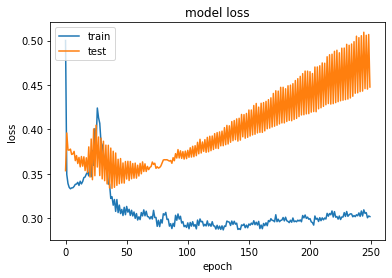

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


**Get items rated by the user and Recommended items**

In [ ]:

def get_rated_items_by_user(user_id):
    items_rated = df[df.reviewerID == user_id]
    # print("items_rated : \n", items_rated)
    return items_rated


def get_items_not_rated_by_user(user_id, items_rated_by_user):
    items_not_rated_by_user = df[~df["asin"].isin(items_rated_by_user.asin.values)]["asin"]
    items_not_rated_by_user_unique = list(set(items_not_rated_by_user).intersection(set(item2item_encoded.keys())))
    items_not_rated_by_user_encoded = [[item2item_encoded.get(x)] for x in items_not_rated_by_user_unique]

    # print(" items_not_rated_by_user : \n", items_not_rated_by_user)

    # returns indices of items: eg: [0, 5, 6]
    return items_not_rated_by_user_encoded


def get_items_with_model_predictions(user_id, items_not_rated_by_user_encoded):
    user_id_encoded = user2user_encoded.get(user_id)

    user_item_array = np.hstack(
        ([[user_id_encoded]] * len(items_not_rated_by_user_encoded), items_not_rated_by_user_encoded)
    )

    ratings = model.predict(user_item_array).flatten()
    # print("ratings is ", ratings)
    # print("ratings is ", ratings.argsort())
    # print("user_item_array one col : ", user_item_array[:, 1])
    # print("user_item_array : ", user_item_array)

    return ratings


def get_top_predicted_items_for_user(user_id, predictions, items_not_rated_by_user_encoded, top_k=15):
    top_ratings_indices = predictions.argsort()[-top_k:][::-1]
    print("top_ratings_indices: ", top_ratings_indices)
    recommended_item_ids = [
        item_encoded2item.get(items_not_rated_by_user_encoded[x][0]) for x in top_ratings_indices
    ]

    for asin, prediction_index in zip(recommended_item_ids, top_ratings_indices):
      print("asin: ", asin, " prediction: ", predictions[prediction_index])

    return recommended_item_ids

def get_top_items_rated_by_user(user_id, items_rated_by_user, top_k=10):
    top_user_items = items_rated_by_user.sort_values(by="overall", ascending=False).head(15)

    for row in top_user_items.itertuples():
      print("asin: ", row.asin, " rating: ", row.overall)


    return list(top_user_items["asin"].unique())

######
# top_rated_items_by_user = get_top_rated_items_by_user(user_id)
user_id = "A276RHM6BBPDTY"

items_rated_by_user = get_rated_items_by_user(user_id)

items_not_rated_by_user_encoded = get_items_not_rated_by_user(user_id, items_rated_by_user)

predictions = get_items_with_model_predictions(user_id, items_not_rated_by_user_encoded)

print("top rated items")
print("=====================")
top_rated_items_for_user = get_top_items_rated_by_user(user_id, items_rated_by_user)
print("=====================")

print("top predicted items")
print("=====================")
top_predicted_items_for_user = get_top_predicted_items_for_user(user_id, predictions, items_not_rated_by_user_encoded)
print("=====================")


#####



top rated items
asin:  B00R14HQEQ  rating:  5.0
asin:  B000SEKSPK  rating:  5.0
asin:  B013OY25GA  rating:  5.0
asin:  B00SIQ00QC  rating:  5.0
asin:  B00TFRAHRK  rating:  5.0
asin:  B00R1GZONE  rating:  5.0
asin:  B00SMYRSKQ  rating:  5.0
asin:  B00OKB7W6A  rating:  5.0
asin:  B000WHTWD2  rating:  5.0
asin:  B00IB1D0IO  rating:  5.0
asin:  B00ULKSSOY  rating:  5.0
asin:  B015IP43MW  rating:  5.0
asin:  B00HZYFPRM  rating:  5.0
asin:  B00RGVOUIO  rating:  5.0
asin:  B00RGUTLMA  rating:  5.0
top predicted items
top_ratings_indices:  [4341 1783 3541 1657 3887 2999 1704 2340 4080   73 3802 4159  667 2109
 4225]
asin:  B00TDFS7K8  prediction:  0.9999999
asin:  B015ZIHSK6  prediction:  0.99999976
asin:  B01FUGUA26  prediction:  0.99999976
asin:  B00UOLHEWW  prediction:  0.99999976
asin:  B012DD8G16  prediction:  0.99999976
asin:  B000XGGX6G  prediction:  0.99999976
asin:  B01H2AYPTC  prediction:  0.99999976
asin:  B00VRJUXIM  prediction:  0.99999976
asin:  B00V1P4Y6O  prediction:  0.9999997

**Import Metadata**

In [ ]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Luxury_Beauty.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Prime_Pantry.json.gz

--2020-08-10 07:32:16--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Prime_Pantry.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5065395 (4.8M) [application/octet-stream]
Saving to: ‘meta_Prime_Pantry.json.gz’

meta_Prime_Pantry.j 100%[===================>]   4.83M  20.1MB/s    in 0.2s    

2020-08-10 07:32:17 (20.1 MB/s) - ‘meta_Prime_Pantry.json.gz’ saved [5065395/5065395]



In [ ]:
def parse(path):
  # asin_metadata = {}
  arr = []
  g = gzip.open(path, 'rb')
  for l in g:
    # data = json.loads(l)
    # arr.append(data)
    yield json.loads(l)
  
  return arr

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    # df[i] = d
    df[d["asin"]] = d
    # i += 1

  # return pd.DataFrame.from_dict(df, orient='index')
  return df

# asin_metadata = parse2('meta_Luxury_Beauty.json.gz')
asin_metadata = getDF('meta_Prime_Pantry.json.gz')


In [ ]:
# asin_metadata.head()
# print(asin_metadata.head())
print(json.dumps(asin_metadata["B00VRJUXIM"]))

{"category": [], "tech1": "", "description": ["For more than 75 years, V8 Vegetable Juice has provided easy ways to help you get the powerful vegetable nutrition you need everyday. V8 juice is the delicious daily habit that supports a balanced lifestyle! Low Sodium V8 juice helps you get 2 servings of vegetables in every nutritious 8-ounce glass with 2/3 less sodium than regular V8 juice. Its also an excellent source of potassium, which helps maintain fluid balance and normal heart rhythm. Diets containing foods that are a good source of potassium and low in sodium may reduce the risk of high blood pressure and stroke.", "", "When you drink a V8, you&#039;re enjoying 1 full serving of vegetables. But that serving also includes a good source of Vitamins A &amp; C and potassium.", "But just the 1 full serving of vegetables is easier to remember."], "fit": "", "title": "V8 Original Low Sodium 100% Vegetable Juice, 5.5 oz. Can (Pack of 24)", "also_buy": [], "image": ["https://images-na.ssl

In [ ]:
print("asin_metadata : " , asin_metadata["B00VRJUXIM"])

asin_metadata :  {'category': [], 'tech1': '', 'description': ['For more than 75 years, V8 Vegetable Juice has provided easy ways to help you get the powerful vegetable nutrition you need everyday. V8 juice is the delicious daily habit that supports a balanced lifestyle! Low Sodium V8 juice helps you get 2 servings of vegetables in every nutritious 8-ounce glass with 2/3 less sodium than regular V8 juice. Its also an excellent source of potassium, which helps maintain fluid balance and normal heart rhythm. Diets containing foods that are a good source of potassium and low in sodium may reduce the risk of high blood pressure and stroke.', '', 'When you drink a V8, you&#039;re enjoying 1 full serving of vegetables. But that serving also includes a good source of Vitamins A &amp; C and potassium.', 'But just the 1 full serving of vegetables is easier to remember.'], 'fit': '', 'title': 'V8 Original Low Sodium 100% Vegetable Juice, 5.5 oz. Can (Pack of 24)', 'also_buy': [], 'image': ['http

In [ ]:
print("top_predicted_items_for_user :", top_predicted_items_for_user)

top_predicted_items_for_user : ['B00TDFS7K8', 'B015ZIHSK6', 'B01FUGUA26', 'B00UOLHEWW', 'B012DD8G16', 'B000XGGX6G', 'B01H2AYPTC', 'B00VRJUXIM', 'B00V1P4Y6O', 'B0146OUE92', 'B00WM1RYBI', 'B00VHNUXHY', 'B01C6Y6HNQ', 'B00U6EFOVA', 'B00SST8FR0']


**Formulate the Json to show the Recomended items on UI**

In [ ]:

# recommended_items_json = {}
def get_item_details_json(items, json_type):
  items_arr = []
  for item in items:
    items_json = {}
    metadata_dict = asin_metadata[item]
    items_json["json_type"] = json_type
    items_json["asin"] = metadata_dict["asin"]
    items_json["title"] = metadata_dict["title"]
    items_json["description"] = metadata_dict["description"]
    
    new_images = list(map(lambda i: str.replace(i, "_SX50_SY65_CR,0,0,50,65_", "_SY500_"), metadata_dict["image"]))
    items_json["images"] = new_images
    items_arr.append(items_json)

  return json.dumps(items_arr)
  

**Items Top rated by the user Json**

In [ ]:
print("recommended_items json array : \n", get_item_details_json(top_predicted_items_for_user, "predicted_items"))


recommended_items json array : 
 [{"json_type": "predicted_items", "asin": "B00TDFS7K8", "title": "Bausch + Lomb Biotrue Contact Lens Solution for Soft Contact Lenses, Multi-Purpose, 10 Ounce Bottle Twinpack (Includes Free Contact Case)", "description": ["Biotrue soft contact lens solution is inspired by your eyes and keeps your contact lenses moist for up to 20 hours*. Biotrue solution utilizes the lubricant eye's have naturally, hyaluronan (HA). Even up to 20 hours, hyaluronan remains on the contact lenses. Biotrue contact lens solution combines a dual disinfection system and PH equal to healthy tears to help provide excellent disinfection for your contact lenses. Biotrue dissolves protein build-up for clear, clean contact lenses when used daily. Biotrue contact lens solution conditions, cleans, removes protein, disinfects, rinses and stores soft (hydrophilic) contact lenses, including silicone hydrogel contact lenses. *Based on laboratory study.", "", "To condition, clean, remove pr

**Top 15 predicted items Json**

In [ ]:
print("Top rated items by a user : ", get_item_details_json(top_rated_items_for_user, "existing_rated_items"))


Top rated items by a user :  [{"json_type": "existing_rated_items", "asin": "B00R14HQEQ", "title": "Special K Kellogg's Cereal, Vanilla Almond, 16.3 Ounce", "description": ["A classic combination of tastes, special K vanilla almond cereal starts the day off right with a feeling of comfort and a delicious crunch that pairs perfectly with milk. A good source of whole grains, the cereal blends rice and whole-grain wheat flakes with roasted almond pieces and sweetens the mix with vanilla and honey flavors. Fortified with iron and loaded with fiber, special K vanilla almond is a perfect beginning point for the morning or pick-me-up snack for the afternoon when sprinkled on yogurt or apple slices."], "images": ["https://images-na.ssl-images-amazon.com/images/I/31yKORPU8UL._SS40_.jpg", "https://images-na.ssl-images-amazon.com/images/I/51GWUPoRs7L._SS40_.jpg", "https://images-na.ssl-images-amazon.com/images/I/31oqyLakZmL._SS40_.jpg", "https://images-na.ssl-images-amazon.com/images/I/41vT6RgPS1